In [2]:
from IPython.core.display import display, HTML
from warnings import filterwarnings
display(HTML("<style>.container { width:100% !important; }</style>"))
# filterwarnings(action='ignore')

In [48]:
# conda
import numpy as np
import scipy.stats as ss
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

from fitter import Fitter

# pip
from evalys.workload import Workload

In [4]:
input_location = '../../swf/METACENTRUM-2013-3.swf'

In [5]:
workload = Workload.from_csv(input_location)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
workload.df

,jobID,submission_time,waiting_time,execution_time,proc_alloc,cpu_used,mem_used,proc_req,user_est,mem_req,status,uid,gid,exe_num,queue,partition,prev_jobs,think_time
0,2,5,2,1053,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
1,3,6,6,928,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
2,4,6,9,778,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,25,-1,-1
3,5,7,15,809,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,21,-1,-1
4,6,10,15,1177,1,-1,-1,1,86400,409600,-1,2,-1,-1,12,21,-1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5731094,5731096,62985547,105400,37737,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,13,-1,-1
5731095,5731097,62985548,105404,27914,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,22,-1,-1
5731096,5731098,62985548,105496,16844,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,5,-1,-1
5731097,5731099,62985553,105495,36524,1,-1,-1,1,86400,409600,-1,182,-1,-1,9,13,-1,-1


In [7]:
# dataframe with processors requests and memory requests, removed -1 and 0 values
df = workload.df
print(df.shape)
df = df[df.mem_req > 0]
print(df.shape)
df = df[df.proc_req > 0]
print(df.shape)
# df = df[df.execution_time > 1]
# print(df.shape)
df = df[['proc_req', 'mem_req']]
print(df.shape)

(5731099, 18)
(5722091, 18)
(5722091, 18)
(5722091, 2)


In [8]:
# Series of memory requests
mem_req = df['mem_req']
print(mem_req.size)
# mem_req = mem_req[mem_req > 0]
# print(mem_req.size)

5722091


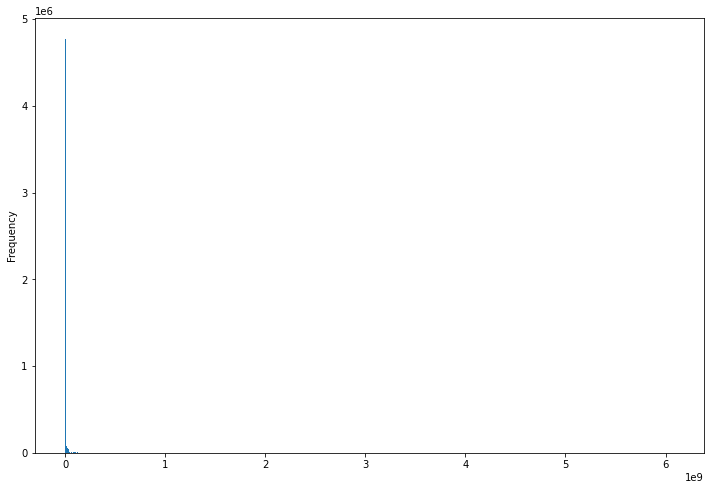

In [45]:
# memory linear histogram
mem_req.plot(kind='hist', bins=1000, loglog=False)

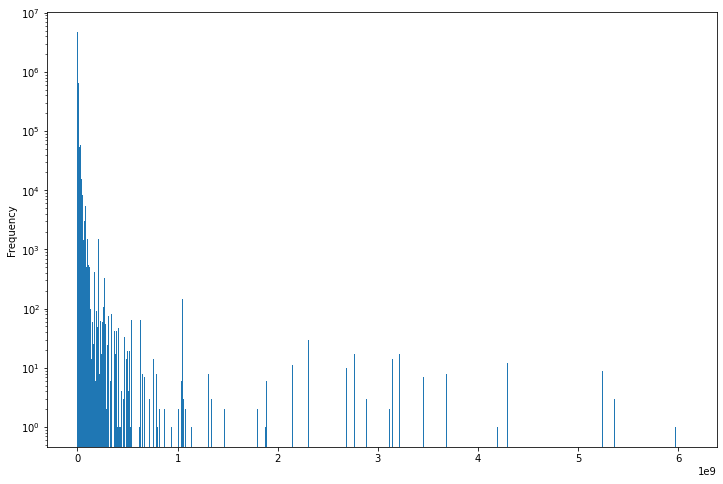

In [46]:
# memory histogram with log y axis with counts
mem_req.plot(kind='hist', bins=1000, logy=True)

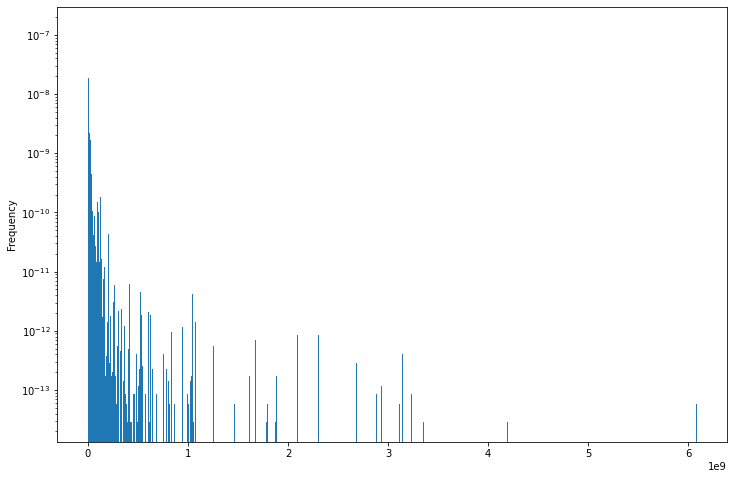

In [47]:
# memory histogram with log y axis with probability
mem_req.plot(kind='hist', density=True, bins=1000, logy=True)

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/seaborn/distributions.py:352: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  ax.set_ylim(0, auto=None)


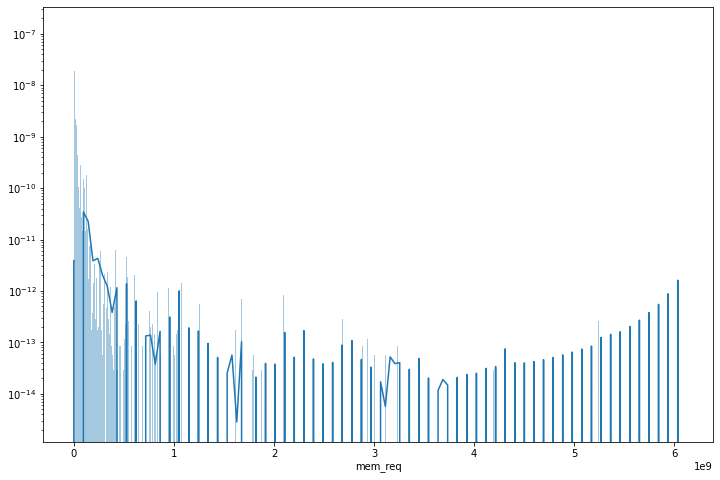

In [48]:
# Seaborn histogram with probability, log y axis, seems to truncate values of prob above 10**-25, kernel density estimation
ax = sns.distplot(mem_req, bins=1000, hist_kws={'log':True})
# ax.set_xscale('log')

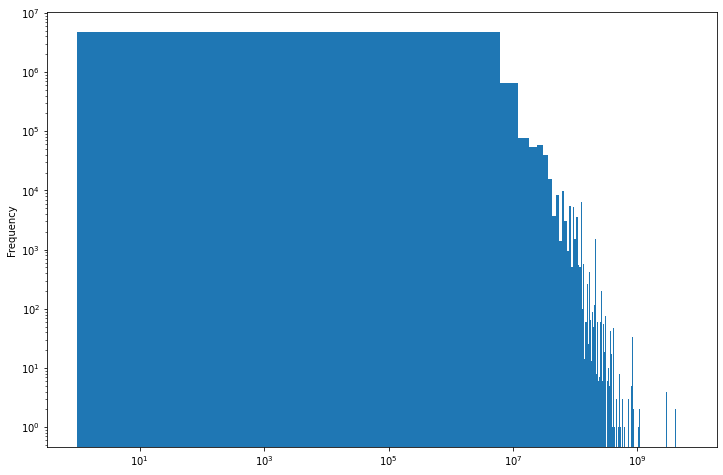

In [49]:
# log log histogram with counts
mem_req.plot(kind='hist', bins=1000, loglog=True)

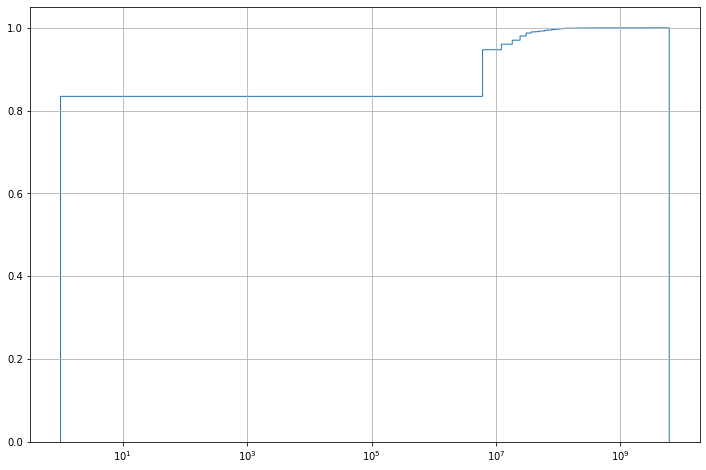

In [50]:
# cdf of mem with log x axis
ax = mem_req.hist(cumulative=True, density=True, bins=1000, histtype='step')
ax.set_xscale('log')

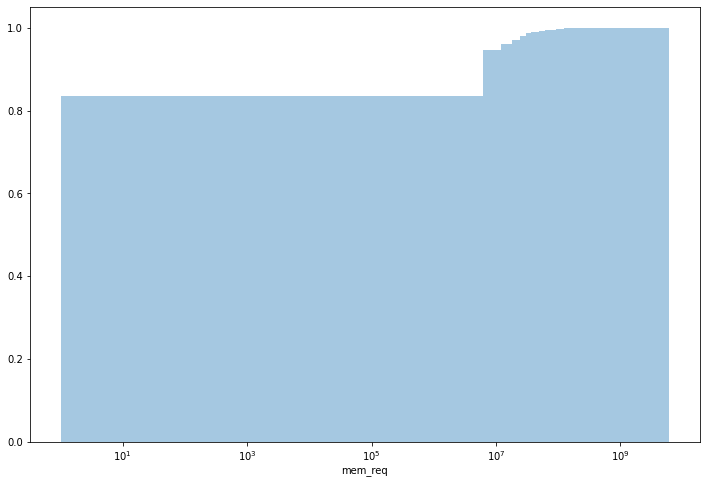

In [51]:
# same as above
ax = sns.distplot(mem_req, kde=False, bins=1000, hist_kws={'cumulative':True, 'density':True})
ax.set_xscale('log')

In [52]:
# mem metrics
mem_req.describe()

count    5.722091e+06
mean     5.192453e+06
std      2.438858e+07
min      1.000000e+00
25%      1.048576e+06
50%      4.194304e+06
75%      4.194304e+06
max      6.081741e+09
Name: mem_req, dtype: float64

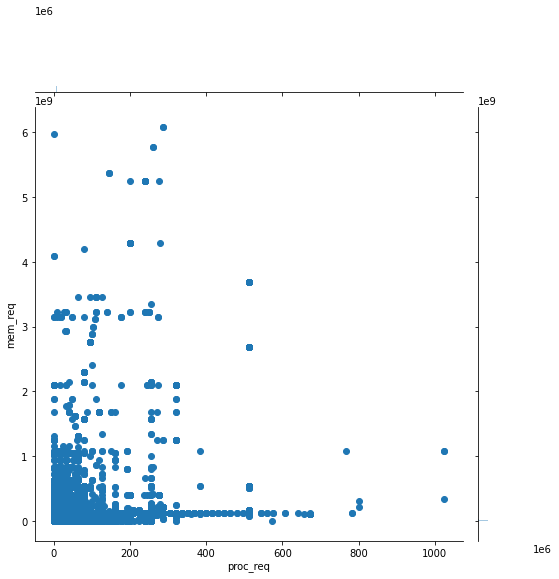

In [54]:
# linear scatter jointplot
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=8, marginal_kws=dict(bins=1000))

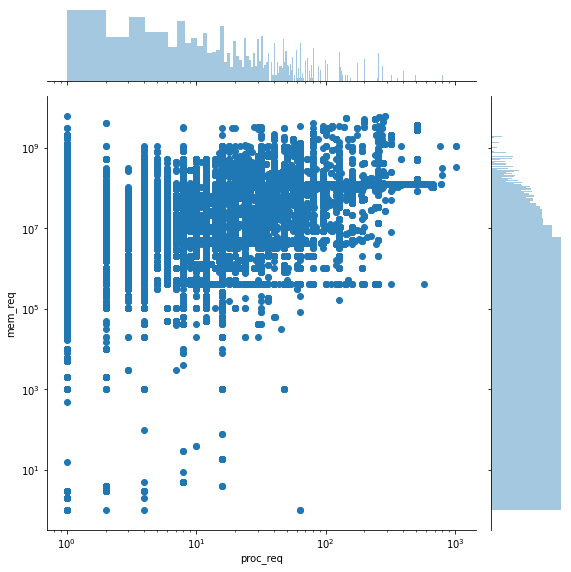

In [55]:
# log log scatter, marginal distribution
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=df, height=8, marginal_kws={'bins':1000,'hist_kws':{'log': True}})
joint_proc_mem.ax_joint.set_yscale('log')
joint_proc_mem.ax_joint.set_xscale('log')

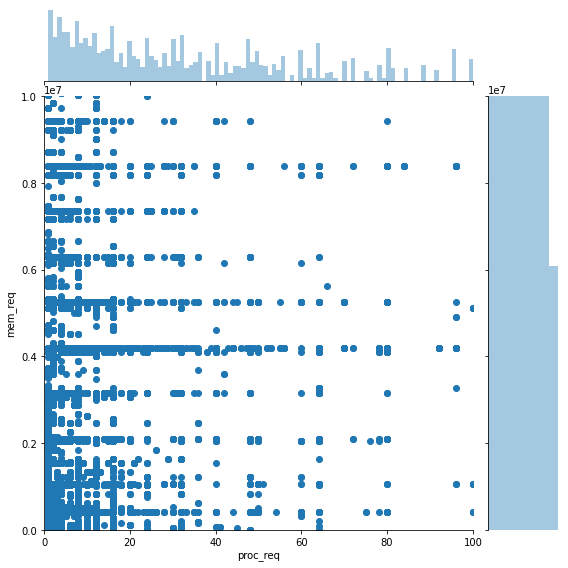

In [66]:
# linear scatter with limits
sns.jointplot(x='proc_req', y='mem_req', data=df, kind='scatter', height=8, ylim=(0,10**7), xlim=(0,10**2), marginal_kws={'bins':1000,'hist_kws':{'log': True}})

In [69]:
# dataframe limited and sampled
plot_sample = df[df.proc_req < 100]
plot_sample = plot_sample[plot_sample.mem_req < 10**7]
plot_sample = plot_sample.sample(n=1000)
plot_sample.shape

(1000, 2)

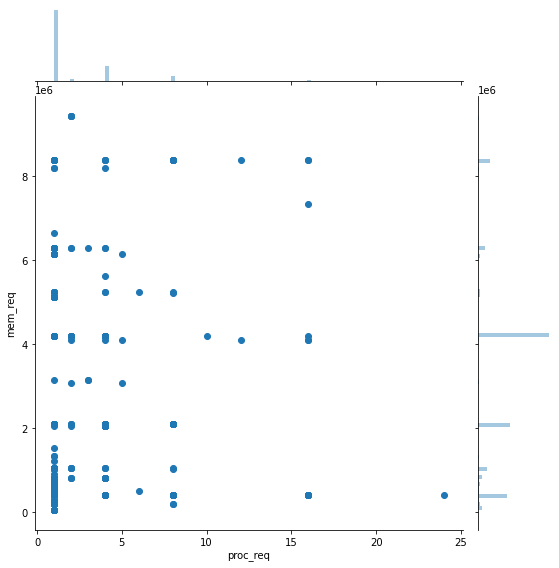

In [71]:
# scatter with samples
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=plot_sample, kind='scatter', height=8, marginal_kws=dict(bins=100))
# joint_proc_mem.ax_joint.set_yscale('log')
# joint_proc_mem.ax_joint.set_xscale('log')

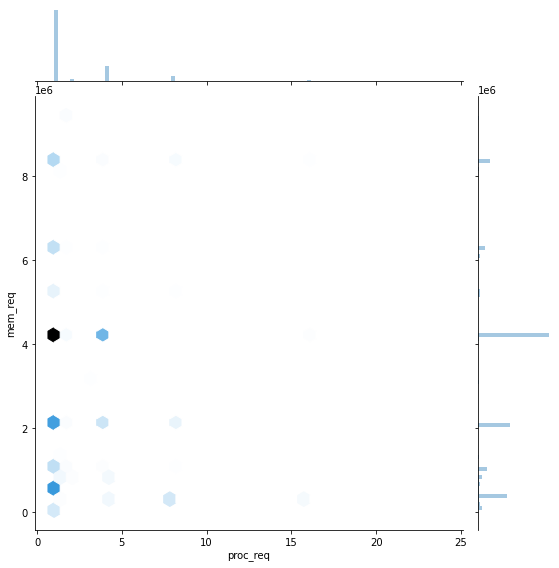

In [72]:
# hex scatter with samples
joint_proc_mem = sns.jointplot(x='proc_req', y='mem_req', data=plot_sample, kind='hex', height=8, marginal_kws=dict(bins=100))

In [59]:
# 14% of probability mass is concentrated on 4GB
# df[df.mem_req > 309600][df.mem_req < 509600]['mem_req'].hist(bins=100)
df[df.mem_req == 409600]['mem_req']
805516 / 5722091

0.14077301462000516

In [60]:
covariance = df.cov().iloc[0,1]
proc_std = df.std()[0]
mem_std = df.std()[1]

In [61]:
correlation_coefficient = covariance / (proc_std * mem_std)
correlation_coefficient

0.3450583483172327

In [62]:
# very wear linear correlation 
df.corr(method='pearson')

,proc_req,mem_req
proc_req,1.000000,0.345058
mem_req,0.345058,1.000000


In [63]:
# no correlation 
df.corr(method='kendall')

,proc_req,mem_req
proc_req,1.00000,0.07337
mem_req,0.07337,1.00000


In [64]:
# no correlation 
df.corr(method='spearman')

,proc_req,mem_req
proc_req,1.000000,0.087583
mem_req,0.087583,1.000000


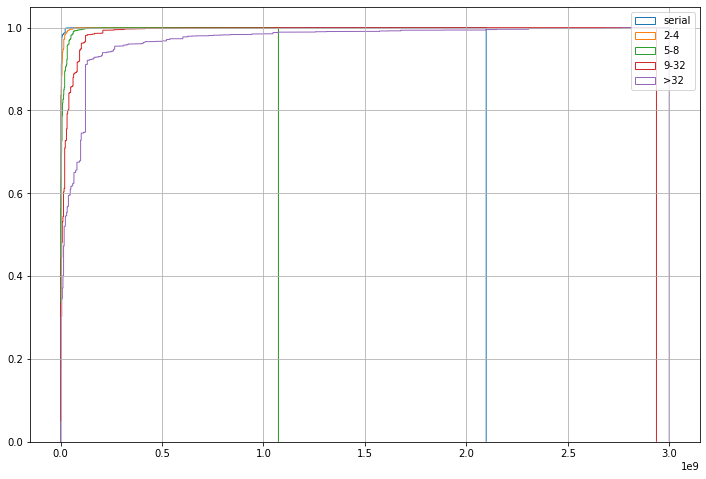

In [65]:
# very weak correlation
cdf_df = df[df.mem_req < 3 * 10**9]
cdf = cdf_df[cdf_df.proc_req == 1]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='serial')
cdf_df[(cdf_df.proc_req > 1) & (cdf_df.proc_req <= 4)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='2-4')
cdf_df[(cdf_df.proc_req > 4) & (cdf_df.proc_req <= 8)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='5-8')
cdf_df[(cdf_df.proc_req > 8) & (cdf_df.proc_req <= 32)]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='9-32')
cdf_df[cdf_df.proc_req > 32]['mem_req'].hist(cumulative=True, density=True, bins=1000, histtype='step', label='>32')
cdf.legend()

In [12]:
mem_limit = 5*10**7
mem_lim = mem_req[mem_req <= mem_limit]

In [19]:
loc_expon, scale_expon = ss.expon.fit(mem_req)
loc_expon, scale_expon

(1.0, 5192451.526500191)

In [20]:
x = np.linspace(mem_lim.min(), mem_lim.max(), 10000)
y_pdf_expon = ss.expon.pdf(x, loc=loc_expon, scale=scale_expon)
y_cdf_expon = ss.expon.cdf(x, loc=loc_expon, scale=scale_expon)

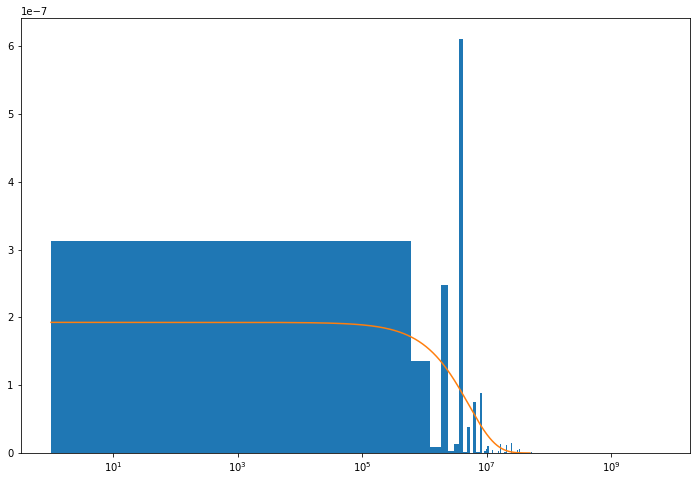

In [21]:
fig, ax = plt.subplots()
ax.set_xscale('log')
# ax.set_yscale('log')
ax.hist(mem_req, bins=10000, density=True)
ax.plot(x, y_pdf_expon)

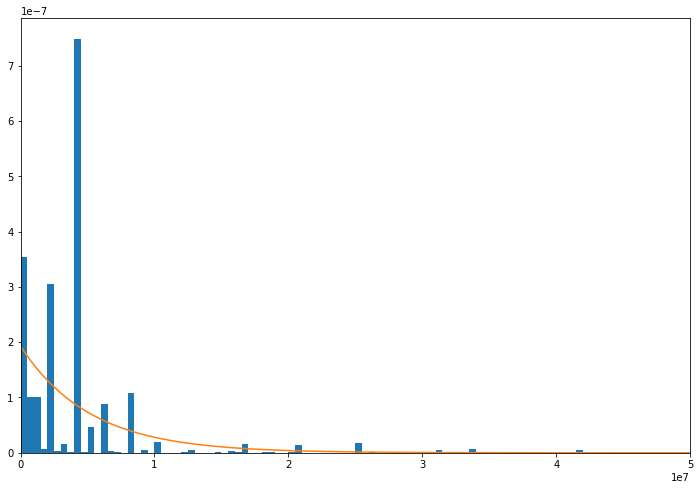

In [22]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_expon)

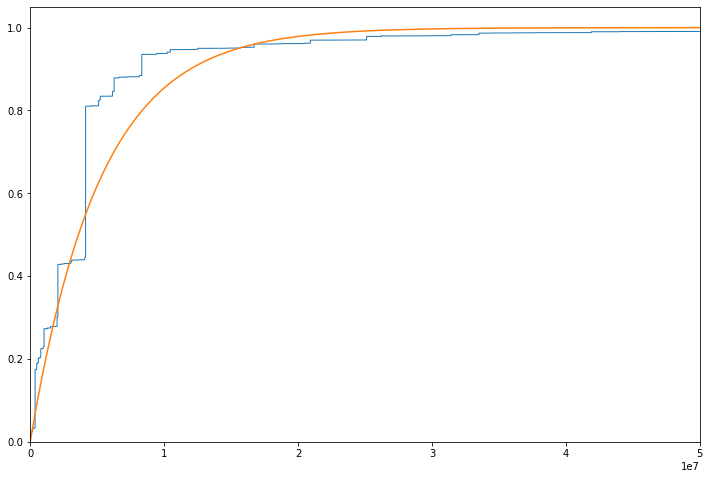

In [23]:
fig, ax = plt.subplots()
# ax.set_xscale('log')
ax.set_xlim(right=mem_limit)
ax.hist(mem_req, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_expon)

In [501]:
a, loc, scale = ss.erlang.fit(mem_req)
a, loc, scale

(0.766769360472922, -124.93246258643205, 6779660.97506615)

In [502]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.erlang.pdf(x, a=a, loc=loc, scale=scale)
y_cdf = ss.erlang.cdf(x, a=a, loc=loc, scale=scale)

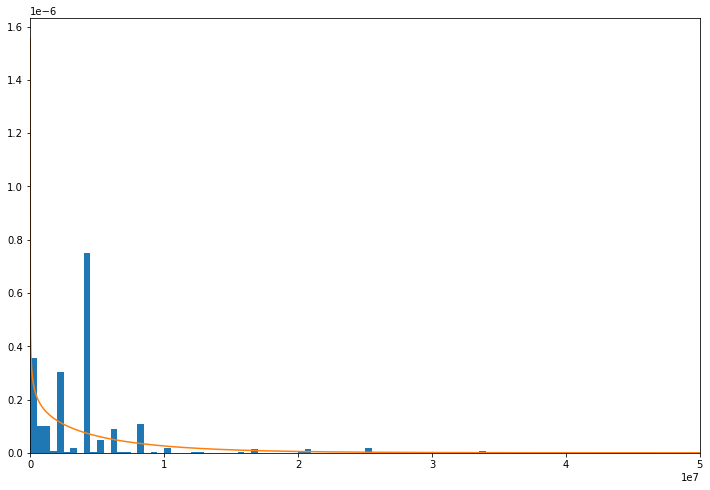

In [503]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

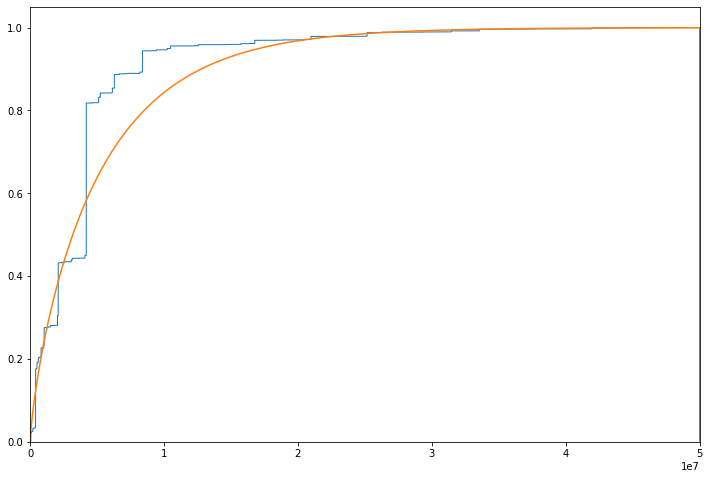

In [504]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [505]:
a, loc, scale = ss.gamma.fit(mem_req)
a, loc, scale

(0.000863742316364836, 6313536772.269705, 7.121602910510014e-24)

In [506]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.gamma.pdf(x, a=a, loc=loc, scale=scale)
y_cdf = ss.gamma.cdf(x, a=a, loc=loc, scale=scale)

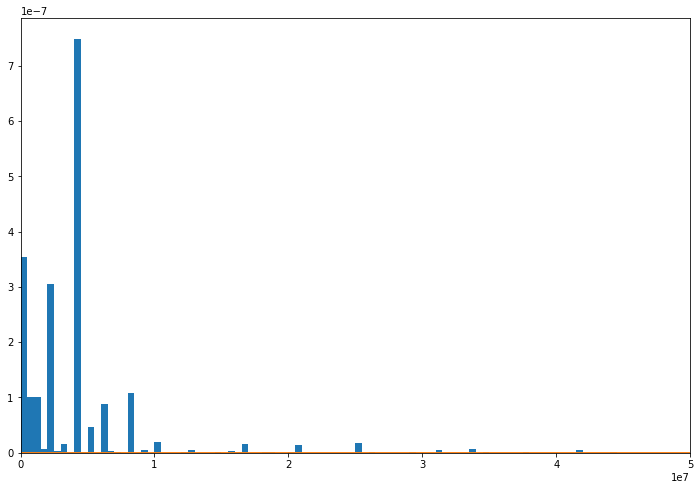

In [507]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

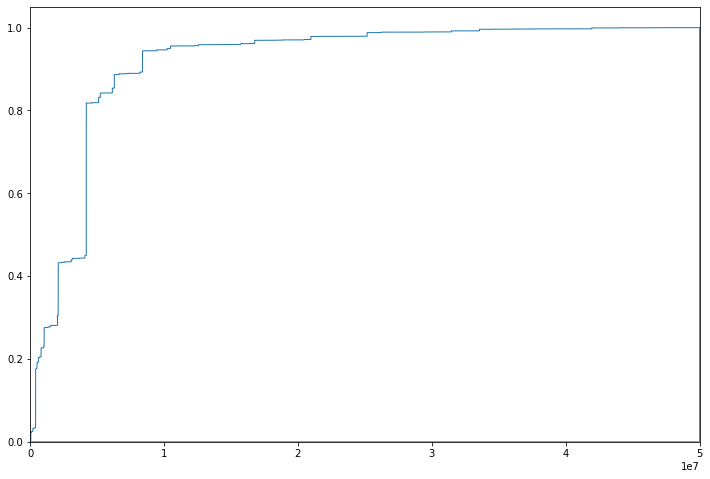

In [509]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [510]:
c, loc, scale = ss.weibull_min.fit(mem_req)
c, loc, scale

(0.7999279430881769, 0.9999999999999999, 4358866.223776371)

In [511]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.weibull_min.pdf(x, c=c, loc=loc, scale=scale)
y_cdf = ss.weibull_min.cdf(x, c=c, loc=loc, scale=scale)

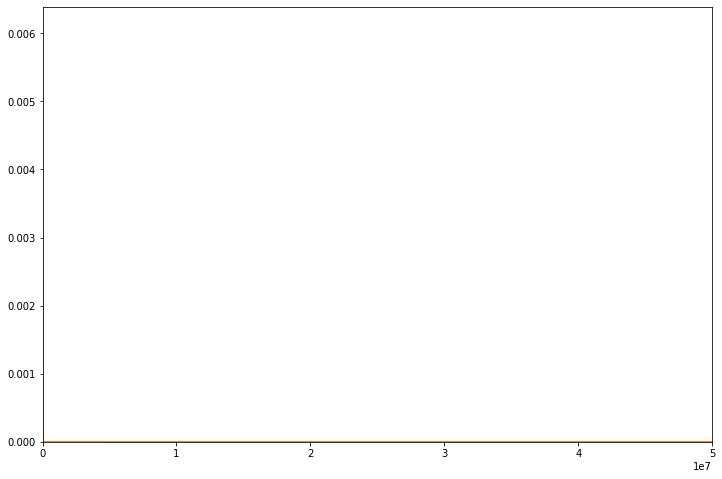

In [515]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

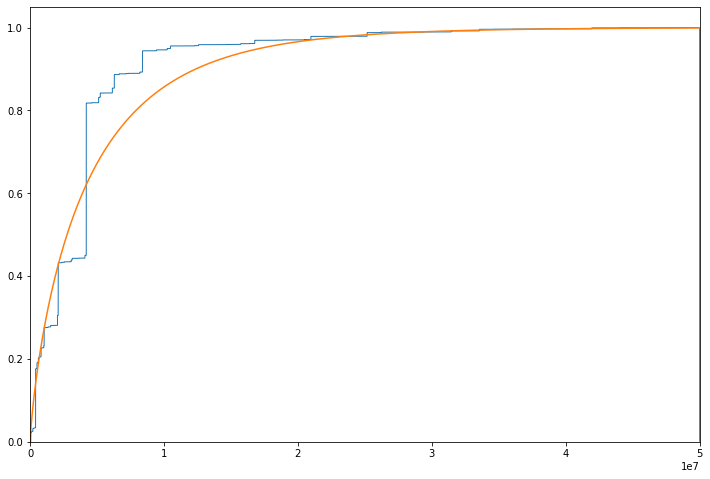

In [514]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [516]:
b, loc, scale = ss.pareto.fit(mem_req)
b, loc, scale

(0.07258365920045476, -1.529464864041959, 2.5294644620914735)

In [517]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.pareto.pdf(x, b=b, loc=loc, scale=scale)
y_cdf = ss.pareto.cdf(x, b=b, loc=loc, scale=scale)

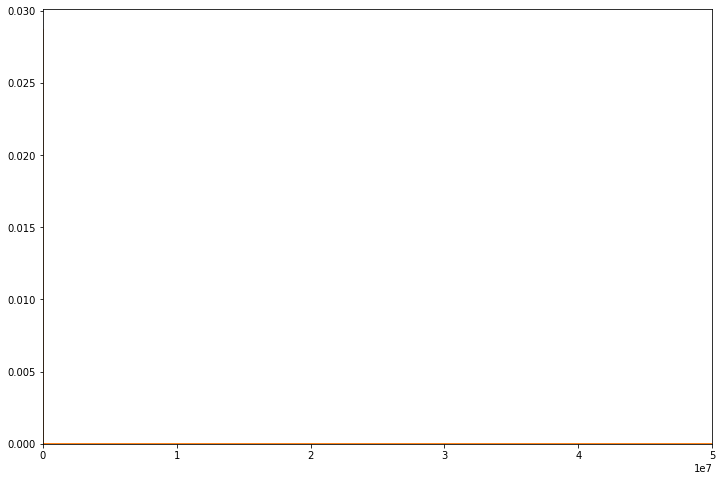

In [518]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

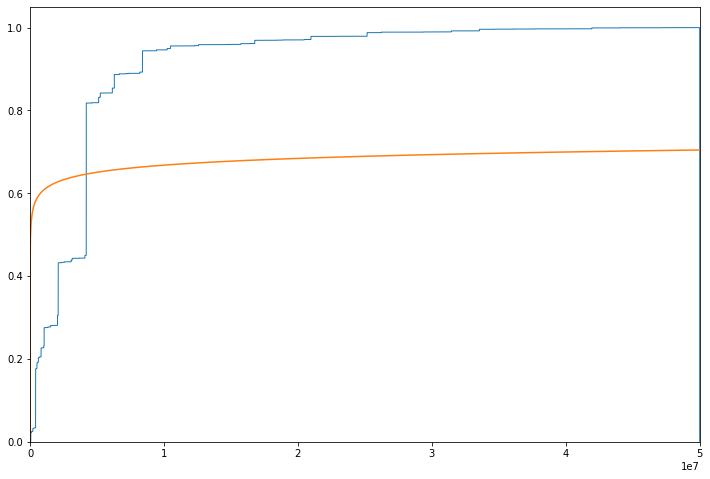

In [519]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [520]:
s, loc, scale = ss.lognorm.fit(mem_req)
s, loc, scale

(1.0972517799795216, -150361.3304133251, 2714115.097037774)

In [522]:
x = np.linspace(mem_req.min(), mem_limit, 10000)
y_pdf = ss.lognorm.pdf(x, s=s, loc=loc, scale=scale)
y_cdf = ss.lognorm.cdf(x, s=s, loc=loc, scale=scale)

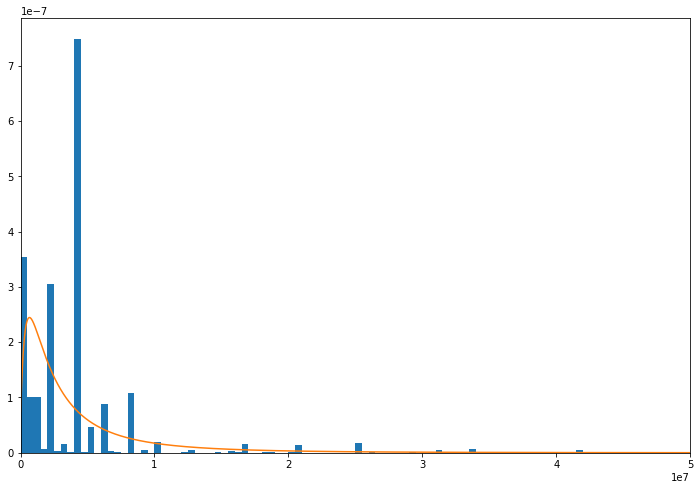

In [523]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf)

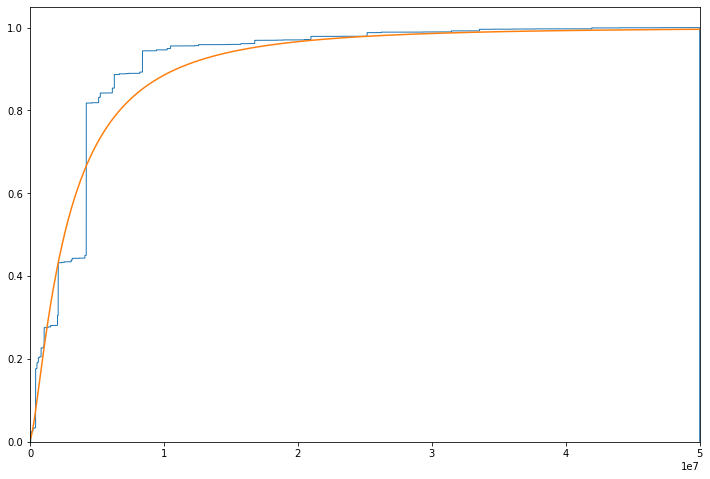

In [524]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf)

In [73]:
fit_sample = df.sample(n=10000)

In [77]:
fitter = Fitter(fit_sample)
fitter.fit()

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2407: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


Fitted alpha distribution with error=8.202826926459685e-15)
Fitted anglit distribution with error=7.841652943590325e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:422: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0/np.pi/np.sqrt(x*(1-x))


Fitted arcsine distribution with error=7.531569328981128e-15)
Fitted argus distribution with error=8.137477206081744e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


Fitted beta distribution with error=7.652038215126244e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:708: RuntimeWarning: divide by zero encountered in true_divide
  a/(b-1.0),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:712: RuntimeWarning: divide by zero encountered in true_divide
  a*(a+1.0)/((b-2.0)*(b-1.0)),
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1063: RuntimeWarning: invalid value encountered in subtract
  mu2 = mu2p - mu * mu


Fitted betaprime distribution with error=8.057742767289334e-15)
Fitted bradford distribution with error=7.0153623217720885e-15)
Fitted burr distribution with error=7.474815157693402e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:951: RuntimeWarning: overflow encountered in power
  return np.log(c) + np.log(d) + sc.xlogy(c - 1, x) + sc.xlog1py(-d-1, x**c)


Fitted burr12 distribution with error=8.057861822905412e-15)
Fitted cauchy distribution with error=8.202893645609877e-15)
Fitted chi distribution with error=3.2977333243858113e-15)
Fitted chi2 distribution with error=2.9371262874009695e-15)
Fitted cosine distribution with error=7.738911507335927e-15)
Fitted crystalball distribution with error=4.0959891768683885e-15)
Fitted dgamma distribution with error=6.8865970147113535e-15)
Fitted dweibull distribution with error=5.662340437966986e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00025.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.00016666666666666666.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.0002777777777777778.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.000462962962962963.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/s

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.312092870664597.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.3108367594977052.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.3100140159716269.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2844: RuntimeWarning: The shape parameter of the erlang distribution has been given a non-integer value 0.31231786482372903.
  warnings.warn(
/usr/local/anaconda3/envs/pybatsim/lib/python3.8

Fitted erlang distribution with error=7.817988159022954e-15)
Fitted expon distribution with error=1.7063187431134527e-15)
Fitted exponnorm distribution with error=1.7327693074086646e-15)
Fitted exponpow distribution with error=4.206342324574536e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:1607: RuntimeWarning: invalid value encountered in add
  logp = (np.log(a) + np.log(c) + sc.xlogy(a - 1.0, exm1c) +


Fitted exponweib distribution with error=7.652584035112869e-15)
Fitted f distribution with error=8.203443181458486e-15)
Fitted fatiguelife distribution with error=4.6459497506716154e-15)
Fitted fisk distribution with error=7.168290047481173e-15)
Fitted foldcauchy distribution with error=8.204519176919832e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


Fitted foldnorm distribution with error=2.944791565802072e-15)
Fitted frechet_l distribution with error=8.209074926168048e-15)
Fitted frechet_r distribution with error=4.441155618116051e-15)
Fitted gamma distribution with error=8.204932365144624e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3373: RuntimeWarning: divide by zero encountered in power
  return 1.0/Cinv * x**(a-1.0) * (1.0-x)**(b-1.0) / (1.0+z*x)**c


Fitted gausshyper distribution with error=5.919521919507197e-15)
Fitted genexpon distribution with error=1.7063186687710308e-15)
Fitted genextreme distribution with error=7.748594884750062e-15)
Fitted gengamma distribution with error=6.564474519494806e-15)
Fitted genhalflogistic distribution with error=5.190590122877682e-16)
Fitted geninvgauss distribution with error=7.832950577808346e-15)
Fitted genlogistic distribution with error=1.4212383355865975e-15)
Fitted gennorm distribution with error=7.924725267927767e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:2432: RuntimeWarning: divide by zero encountered in true_divide
  val = val + cnk * (-1) ** ki / (1.0 - c * ki)


Fitted genpareto distribution with error=8.1654125433106e-15)
Fitted gilbrat distribution with error=5.970298684684246e-15)
Fitted gompertz distribution with error=1.7184881933463623e-15)
Fitted gumbel_l distribution with error=7.786314457427436e-15)
Fitted gumbel_r distribution with error=1.429522143595245e-15)
Fitted halfcauchy distribution with error=8.200797392616957e-15)
Fitted halfgennorm distribution with error=5.456885086580999e-15)
Fitted halflogistic distribution with error=5.238569216514197e-16)
Fitted halfnorm distribution with error=1.9872361449345473e-15)
Fitted hypsecant distribution with error=2.0914121219688992e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:3322: RuntimeWarning: overflow encountered in cosh
  return 1.0/(np.pi*np.cosh(x))


Fitted invgamma distribution with error=8.201649040738759e-15)
Fitted invgauss distribution with error=8.204003260453415e-15)
Fitted invweibull distribution with error=7.649493677604697e-15)
Fitted johnsonsb distribution with error=7.527862620887185e-15)
Fitted johnsonsu distribution with error=8.2047280264482e-15)
Fitted kappa3 distribution with error=7.66737490696742e-15)
Fitted kappa4 distribution with error=8.037593268376015e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:97: RuntimeWarning: floating point number truncated to an integer
  return -scu._smirnovp(n, x)


Fitted ksone distribution with error=8.11828056513028e-15)
Fitted kstwobign distribution with error=2.3731407995945657e-15)
Fitted laplace distribution with error=4.344071261135436e-15)
Fitted levy distribution with error=8.204932364893122e-15)
Fitted levy_l distribution with error=8.173219018614584e-15)
SKIPPED levy_stable distribution (taking more than 30 seconds)
SKIPPED loggamma distribution (taking more than 30 seconds)
Fitted logistic distribution with error=1.2519278717443535e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4798: RuntimeWarning: divide by zero encountered in true_divide
  return c**2 / (c**2 - n**2)
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:4789: RuntimeWarning: divide by zero encountered in power
  return cd2*x**(c-1)


Fitted loglaplace distribution with error=7.592092307982686e-15)
SKIPPED lognorm distribution (taking more than 30 seconds)
Fitted loguniform distribution with error=8.204932365144624e-15)
Fitted lomax distribution with error=8.203893914485755e-15)
Fitted maxwell distribution with error=3.601872549856013e-15)
SKIPPED mielke distribution (taking more than 30 seconds)
Fitted moyal distribution with error=1.9594734001457654e-15)
SKIPPED nakagami distribution (taking more than 30 seconds)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:1702: RuntimeWarning: invalid value encountered in log
  return log(self._pdf(x, *args))


SKIPPED ncf distribution (taking more than 30 seconds)
SKIPPED nct distribution (taking more than 30 seconds)
SKIPPED ncx2 distribution (taking more than 30 seconds)
Fitted norm distribution with error=3.916893450314755e-15)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5836: RuntimeWarning: invalid value encountered in multiply
  Px *= trm1+trm2
/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:5832: RuntimeWarning: overflow encountered in multiply
  trm1 = np.sqrt(2)*nc*x*sc.hyp1f1(n/2+1, 1.5, valF)


Fitted norminvgauss distribution with error=8.199120636787857e-15)
SKIPPED pareto distribution (taking more than 30 seconds)
SKIPPED pearson3 distribution (taking more than 30 seconds)
SKIPPED powerlaw distribution (taking more than 30 seconds)
SKIPPED powerlognorm distribution (taking more than 30 seconds)
SKIPPED powernorm distribution (taking more than 30 seconds)
Fitted rayleigh distribution with error=2.6114820022856807e-15)
SKIPPED rdist distribution (taking more than 30 seconds)
SKIPPED recipinvgauss distribution (taking more than 30 seconds)
Fitted reciprocal distribution with error=8.204932365144624e-15)
SKIPPED rice distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
Fitted semicircular distribution with error=7.91152757045479e-15)
SKIPPED skewnorm distribution (taking more than 30 seconds)
Fitted t distribution with error=8.151227588661642e-15)
Fitted trapz

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/stats/_continuous_distns.py:7248: RuntimeWarning: divide by zero encountered in power
  Px = Fx**(lam-1.0) + (np.asarray(1-Fx))**(lam-1.0)


SKIPPED tukeylambda distribution (taking more than 30 seconds)
Fitted uniform distribution with error=8.118196191184226e-15)
SKIPPED vonmises distribution (taking more than 30 seconds)
SKIPPED vonmises_line distribution (taking more than 30 seconds)
Fitted wald distribution with error=4.239644431915397e-15)
Fitted weibull_max distribution with error=8.209074926168048e-15)
Fitted weibull_min distribution with error=4.441155618116051e-15)
Fitted wrapcauchy distribution with error=nan)


/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/scipy/optimize/optimize.py:597: RuntimeWarning: invalid value encountered in subtract
  numpy.max(numpy.abs(fsim[0] - fsim[1:])) <= fatol):


In [85]:
pd.options.display.max_rows = 100
fitter.summary(Nbest=100, plot=False, method='sumsquare_error')

,sumsquare_error,aic,bic,kl_div
genhalflogistic,5.190590e-16,5.143141e+04,-9.019303e+05,inf
halflogistic,5.238569e-16,5.112316e+04,-9.017562e+05,inf
logistic,1.251928e-15,5.623114e+04,-8.843318e+05,inf
genlogistic,1.421238e-15,5.078051e+04,-8.817850e+05,inf
gumbel_r,1.429522e-15,5.090287e+04,-8.816787e+05,inf
genexpon,1.706319e-15,4.387512e+04,-8.781090e+05,inf
expon,1.706319e-15,4.386912e+04,-8.781387e+05,inf
gompertz,1.718488e-15,4.398730e+04,-8.779867e+05,inf
exponnorm,1.732769e-15,4.406852e+04,-8.778212e+05,inf
moyal,1.959473e-15,4.659866e+04,-8.753720e+05,inf


In [24]:
loc_halflogistic, scale_halflogistic = ss.halflogistic.fit(mem_req)
loc_halflogistic, scale_halflogistic

(0.9999957379964148, 3776381.9680622933)

In [25]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_halflogistic = ss.halflogistic.pdf(x, loc=loc_halflogistic, scale=scale_halflogistic)
y_cdf_halflogistic = ss.halflogistic.cdf(x, loc=loc_halflogistic, scale=scale_halflogistic)

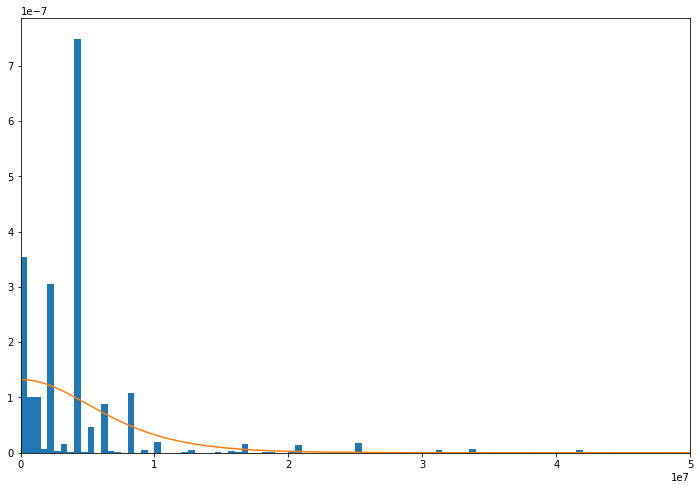

In [26]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_halflogistic)

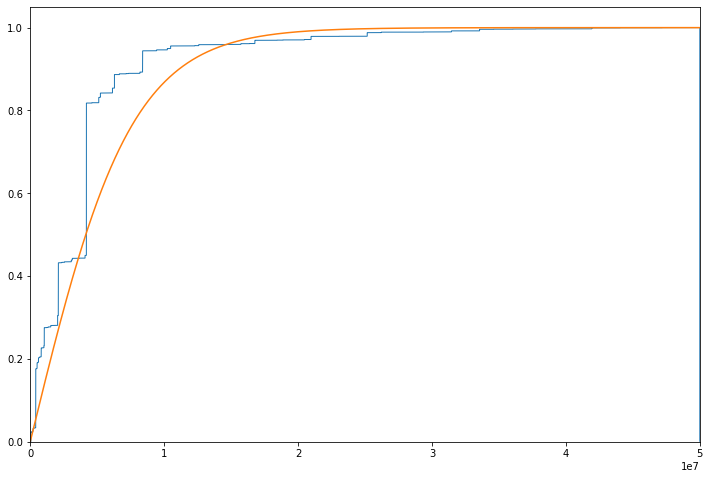

In [27]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_halflogistic)

In [31]:
loc_logistic, scale_logistic = ss.logistic.fit(mem_req)
loc_logistic, scale_logistic

(3511178.443846162, 2769285.7608062048)

In [34]:
x = np.linspace(mem_lim.min(), mem_limit, 10000)
y_pdf_logistic = ss.logistic.pdf(x, loc=loc_logistic, scale=scale_logistic)
y_cdf_logistic = ss.logistic.cdf(x, loc=loc_logistic, scale=scale_logistic)

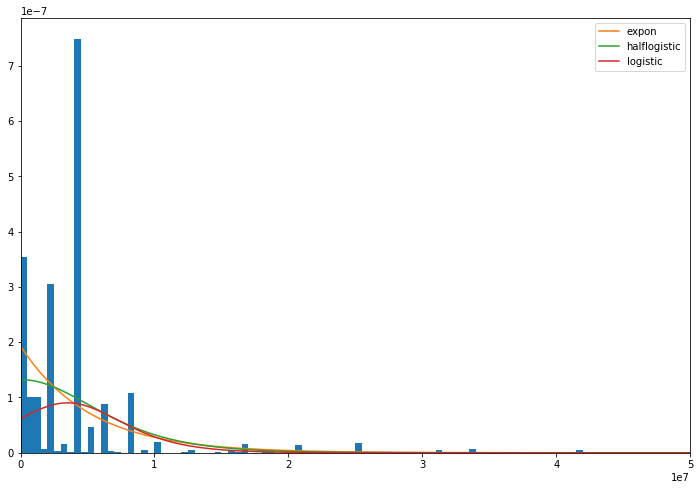

In [35]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, bins=100, density=True)
ax.plot(x, y_pdf_expon, label='expon')
ax.plot(x, y_pdf_halflogistic, label='halflogistic')
ax.plot(x, y_pdf_logistic, label='logistic')
ax.legend()

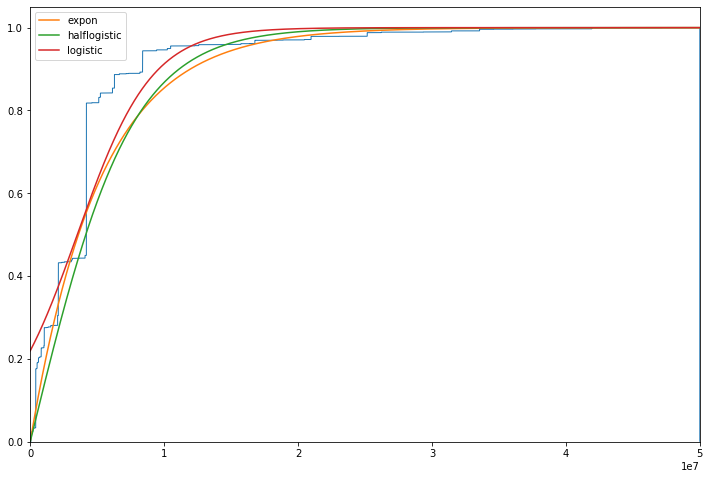

In [36]:
fig, ax = plt.subplots()
ax.set_xlim(right=mem_limit)
ax.hist(mem_lim, density=True, cumulative=True, bins=100000, histtype='step')
ax.plot(x, y_cdf_expon, label='expon')
ax.plot(x, y_cdf_halflogistic, label='halflogistic')
ax.plot(x, y_cdf_logistic, label='logistic')
ax.legend()

In [41]:
ss.kstest(mem_req, ss.expon(loc=loc_expon, scale=scale_expon).cdf, N=1000)

KstestResult(statistic=0.2562073778175842, pvalue=0.0)

In [42]:
ss.kstest(mem_req, ss.logistic(loc=loc_logistic, scale=scale_logistic).cdf, N=1000)

KstestResult(statistic=0.2489968618711269, pvalue=0.0)

In [43]:
ss.kstest(mem_req, ss.halflogistic(loc=loc_halflogistic, scale=scale_halflogistic).cdf, N=1000)

KstestResult(statistic=0.30584896812753004, pvalue=0.0)

In [45]:
ss.anderson(mem_req, 'expon')

AndersonResult(statistic=307208.03267262504, critical_values=array([0.922, 1.078, 1.341, 1.606, 1.957]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]))

In [46]:
ss.anderson(mem_req, 'logistic')

/usr/local/anaconda3/envs/pybatsim/lib/python3.8/site-packages/pandas/core/series.py:856: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


AndersonResult(statistic=inf, critical_values=array([0.426, 0.563, 0.66 , 0.769, 0.906, 1.01 ]), significance_level=array([25. , 10. ,  5. ,  2.5,  1. ,  0.5]))

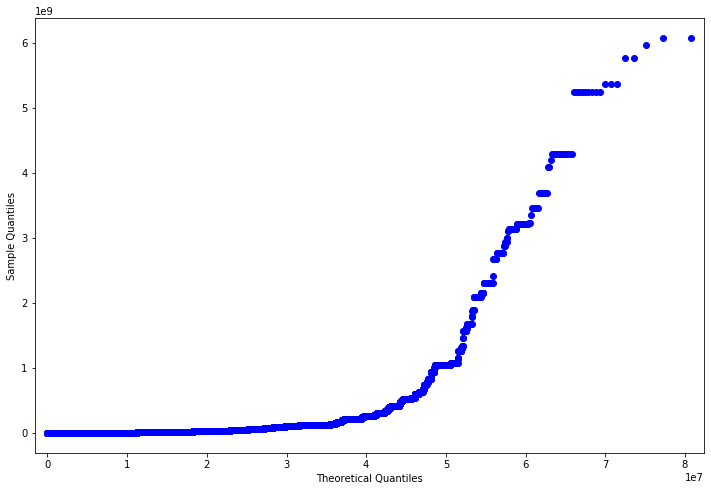

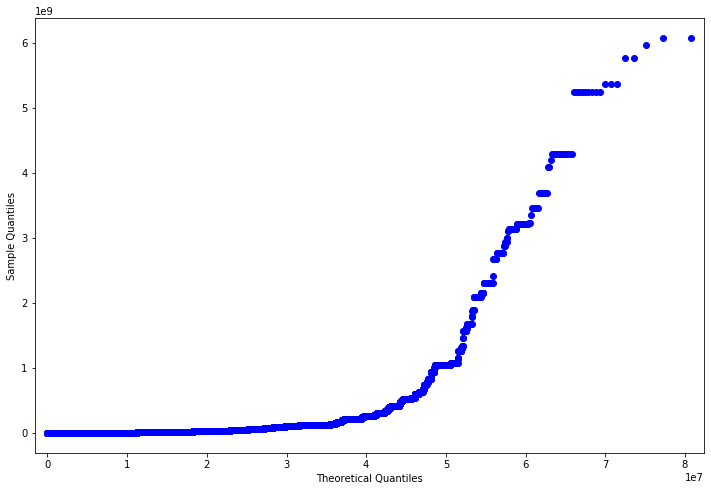

In [52]:
sm.ProbPlot(mem_req, dist=ss.expon, loc=loc_expon, scale=scale_expon).qqplot()

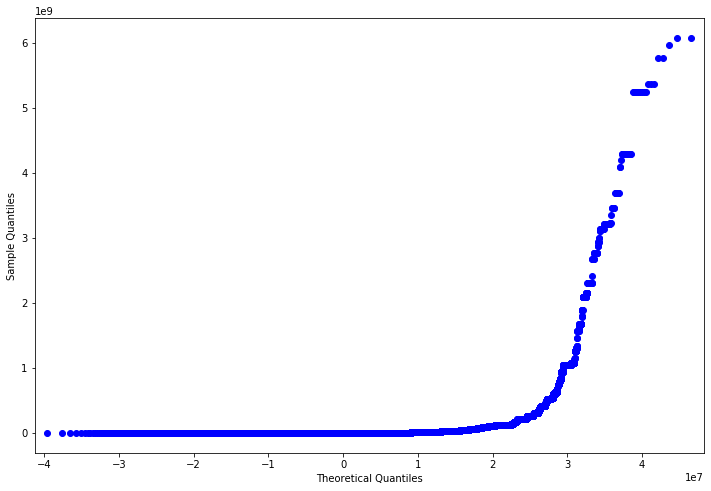

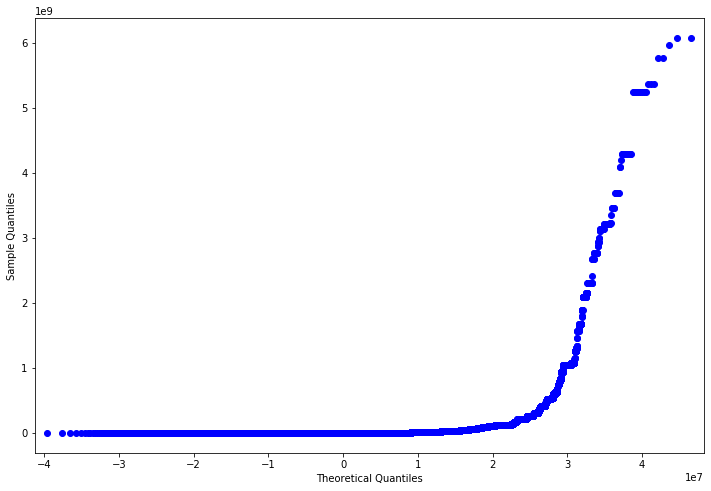

In [53]:
sm.ProbPlot(mem_req, dist=ss.logistic, loc=loc_logistic, scale=scale_logistic).qqplot()

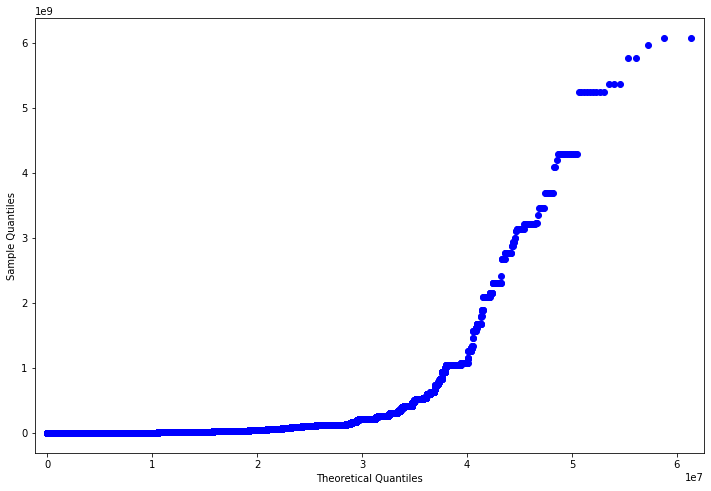

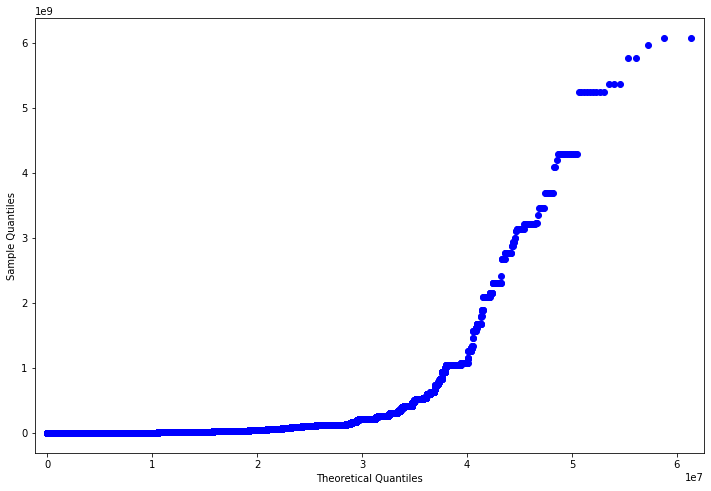

In [54]:
sm.ProbPlot(mem_req, dist=ss.halflogistic, loc=loc_halflogistic, scale=scale_halflogistic).qqplot()